In [9]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report
import matplotlib.pyplot as plt
import tqdm
import seaborn as sns

In [2]:
random_state = 42
n_bootstraped_samples = 100

In [3]:
def map_rating_class(rating: float):
    return round(rating / 0.5) * 0.5

In [4]:
def align_dfs(true_df, pred_df):
    if true_df.shape != pred_df.shape:
        raise ValueError("The input dataframe have different dimensions")
    df = pd.merge(true_df, pred_df, on="RatingID")
    # print(df.head())
    return df

In [5]:
def bootstrap_rmse(y_true, y_pred, n_bootstrap=n_bootstraped_samples, ci=95, random_state=random_state):
    rng = np.random.default_rng(random_state)
    rmse_score = []

    n = len(y_true)
    for _ in range(n_bootstrap):
        indices = rng.choice(n, size=n, replace=True)
        sample_true = y_true[indices]
        sample_pred = y_pred[indices]
        
        rmse = root_mean_squared_error(sample_true, sample_pred)
        rmse_score.append(rmse)

    # Convert to numpy for easy math
    rmse_score = np.array(rmse_score)

    # Confidence interval
    lower = np.percentile(rmse_score, (100 - ci) / 2)
    upper = np.percentile(rmse_score, 100 - (100 - ci) / 2)

    return {
        'rmse_distribution': rmse_score,
        'mean': f"{rmse_score.mean():.4f}",
        'ci': f"[{lower:.4f}, {upper:.4f}]"
    }

In [6]:
# read all true y datasets
true_cold_user_cold_item = pd.read_csv(r"../../testset_cold_user_cold_item.csv")
true_cold_user_warm_item = pd.read_csv(r"../../testset_cold_user_warm_item.csv")
true_warm_user_cold_item = pd.read_csv(r"../../testset_warm_user_cold_item.csv")
true_warm_user_warm_item = pd.read_csv(r"../../testset_warm_user_warm_item.csv")

# only keep ReviewID, Rating
true_cold_user_cold_item = true_cold_user_cold_item[["RatingID", "Rating"]]
true_cold_user_warm_item = true_cold_user_warm_item[["RatingID", "Rating"]]
true_warm_user_cold_item = true_warm_user_cold_item[["RatingID", "Rating"]]
true_warm_user_warm_item = true_warm_user_warm_item[["RatingID", "Rating"]]

In [7]:
# read all predicted y datasets
vincent_cold_user_cold_item = pd.read_csv(r"./model_based_vincent/predictions_CU_CI.csv")
vincent_cold_user_warm_item = pd.read_csv(r"./model_based_vincent/predictions_CU_WI.csv")
vincent_warm_user_cold_item = pd.read_csv(r"./model_based_vincent/predictions_WU_CI.csv")
vincent_warm_user_warm_item = pd.read_csv(r"./model_based_vincent/predictions_WU_WI.csv")

# rename PredictedRating col to Rating
vincent_cold_user_cold_item = vincent_cold_user_cold_item.rename(columns={"PredictedRating": "Rating"})
vincent_cold_user_warm_item = vincent_cold_user_warm_item.rename(columns={"PredictedRating": "Rating"})
vincent_warm_user_cold_item = vincent_warm_user_cold_item.rename(columns={"PredictedRating": "Rating"})
vincent_warm_user_warm_item = vincent_warm_user_warm_item.rename(columns={"PredictedRating": "Rating"})

In [13]:
lightgbm_cold_user_cold_item = pd.read_csv(r"./hybrid-lgbm/hybrid-lgbm_cold_user_cold_item.csv")
lightgbm_cold_user_warm_item = pd.read_csv(r"./hybrid-lgbm/hybrid-lgbm_cold_user_warm_item.csv")
lightgbm_warm_user_cold_item = pd.read_csv(r"./hybrid-lgbm/hybrid-lgbm_warm_user_cold_item.csv")
lightgbm_warm_user_warm_item = pd.read_csv(r"./hybrid-lgbm/hybrid-lgbm_warm_user_warm_item.csv")

In [14]:
svd_cold_user_cold_item = pd.read_csv(r"./svd/svd_cold_user_cold_item.csv")
svd_cold_user_warm_item = pd.read_csv(r"./svd/svd_cold_user_warm_item.csv")
svd_warm_user_cold_item = pd.read_csv(r"./svd/svd_warm_user_cold_item.csv")
svd_warm_user_warm_item = pd.read_csv(r"./svd/svd_warm_user_warm_item.csv")

In [16]:
xgboost_cold_user_cold_item = pd.read_csv(r"./hybrid-xgb/hybrid-xgb_cold_user_cold_item.csv")
xgboost_cold_user_warm_item = pd.read_csv(r"./hybrid-xgb/hybrid-xgb_cold_user_warm_item.csv")
xgboost_warm_user_cold_item = pd.read_csv(r"./hybrid-xgb/hybrid-xgb_warm_user_cold_item.csv")
xgboost_warm_user_warm_item = pd.read_csv(r"./hybrid-xgb/hybrid-xgb_warm_user_warm_item.csv")

In [17]:
graph_sage_cold_user_cold_item = pd.read_csv(r"./graph_sage/results_graphsage_cold_user_cold_item.csv")
graph_sage_cold_user_warm_item = pd.read_csv(r"./graph_sage/results_graphsage_cold_user_warm_item.csv")
graph_sage_warm_user_cold_item = pd.read_csv(r"./graph_sage/results_graphsage_warm_user_cold_item.csv")
graph_sage_warm_user_warm_item = pd.read_csv(r"./graph_sage/results_graphsage_warm_user_warm_item.csv")

graph_sage_cold_user_cold_item = graph_sage_cold_user_cold_item[["RatingID", "Rating_Pred_Tensor"]]
graph_sage_cold_user_warm_item = graph_sage_cold_user_warm_item[["RatingID", "Rating_Pred_Tensor"]]
graph_sage_warm_user_cold_item = graph_sage_warm_user_cold_item[["RatingID", "Rating_Pred_Tensor"]]
graph_sage_warm_user_warm_item = graph_sage_warm_user_warm_item[["RatingID", "Rating_Pred_Tensor"]]

graph_sage_cold_user_cold_item = graph_sage_cold_user_cold_item.rename(columns={"Rating_Pred_Tensor": "Rating"})
graph_sage_cold_user_warm_item = graph_sage_cold_user_warm_item.rename(columns={"Rating_Pred_Tensor": "Rating"})
graph_sage_warm_user_cold_item = graph_sage_warm_user_cold_item.rename(columns={"Rating_Pred_Tensor": "Rating"})
graph_sage_warm_user_warm_item = graph_sage_warm_user_warm_item.rename(columns={"Rating_Pred_Tensor": "Rating"})

In [18]:
predicted_cold_user_cold_item_datasets = {
    "vincent_cold_user_cold_item" : vincent_cold_user_cold_item,
    "lightgbm_cold_user_cold_item" : lightgbm_cold_user_cold_item,
    "svd_cold_user_cold_item" : svd_cold_user_cold_item,
    "xgboost_cold_user_cold_item" : xgboost_cold_user_cold_item,
    "graph_sage_cold_user_cold_item": graph_sage_cold_user_cold_item,
}

predicted_cold_user_warm_item_datasets = {
    "vincent_cold_user_warm_item" : vincent_cold_user_warm_item,
    "lightgbm_cold_user_warm_item" : lightgbm_cold_user_warm_item,
    "svd_cold_user_warm_item" : svd_cold_user_warm_item,
    "xgboost_cold_user_warm_item" : xgboost_cold_user_warm_item,
    "graph_sage_cold_user_warm_item" : graph_sage_cold_user_warm_item,
}

predicted_warm_user_cold_item_datasets = {
    "vincent_warm_user_cold_item" : vincent_warm_user_cold_item,
    "lightgbm_warm_user_cold_item" : lightgbm_warm_user_cold_item,
    "svd_warm_user_cold_item" : svd_warm_user_cold_item,
    "xgboost_warm_user_cold_item" : xgboost_warm_user_cold_item,
    "graph_sage_warm_user_cold_item": graph_sage_warm_user_cold_item,
}

predicted_warm_user_warm_item_datasets = {
    "vincent_warm_user_warm_item" : vincent_warm_user_warm_item,
    "lightgbm_warm_user_warm_item" : lightgbm_warm_user_warm_item,
    "svd_warm_user_warm_item" : svd_warm_user_warm_item,
    "xgboost_warm_user_warm_item" : xgboost_warm_user_warm_item,
    "graph_sage_warm_user_warm_item": graph_sage_warm_user_warm_item
}

predicted_segments = {
    "Hot user/Hot Wine": (true_warm_user_warm_item, predicted_warm_user_warm_item_datasets),
    "Hot User/Cold Wine": (true_warm_user_cold_item, predicted_warm_user_cold_item_datasets),
    "Cold User/Hot Wine": (true_cold_user_warm_item, predicted_cold_user_warm_item_datasets),
    "Cold User/Cold Wine": (true_cold_user_cold_item, predicted_cold_user_cold_item_datasets)
}

## RMSE regression evaluation (combined testsets)

In [32]:
true_all = [true_cold_user_cold_item, true_cold_user_warm_item, true_warm_user_cold_item, true_warm_user_warm_item]
vincent_all = [vincent_cold_user_cold_item, vincent_cold_user_warm_item, vincent_warm_user_cold_item, vincent_warm_user_warm_item]
lightgbm_all = [lightgbm_cold_user_cold_item, lightgbm_cold_user_warm_item, lightgbm_warm_user_cold_item, lightgbm_warm_user_warm_item]
svd_all = [svd_cold_user_cold_item, svd_cold_user_warm_item, svd_warm_user_cold_item, svd_warm_user_warm_item]
xgboost_all = [xgboost_cold_user_cold_item, xgboost_cold_user_warm_item, xgboost_warm_user_cold_item, xgboost_warm_user_warm_item]
graph_sage_all = [graph_sage_cold_user_cold_item, graph_sage_cold_user_warm_item, graph_sage_warm_user_cold_item, graph_sage_warm_user_warm_item]

true_all = pd.concat([*true_all])
vincent_all = pd.concat([*vincent_all])
lightgbm_all = pd.concat([*lightgbm_all])
svd_all = pd.concat([*svd_all])
xgboost_all = pd.concat([*xgboost_all])
graph_sage_all = pd.concat([*graph_sage_all])


aligned = align_dfs(true_all, vincent_all)
y_true = aligned['Rating_x'].values
y_pred = aligned['Rating_y'].values
vincent_all_results = bootstrap_rmse(y_true, y_pred)

aligned = align_dfs(true_all, lightgbm_all)
y_true = aligned['Rating_x'].values
y_pred = aligned['Rating_y'].values
lightgbm_all_results = bootstrap_rmse(y_true, y_pred)

aligned = align_dfs(true_all, svd_all)
y_true = aligned['Rating_x'].values
y_pred = aligned['Rating_y'].values
svd_all_results = bootstrap_rmse(y_true, y_pred)

aligned = align_dfs(true_all, xgboost_all)
y_true = aligned['Rating_x'].values
y_pred = aligned['Rating_y'].values
xgboost_all_results = bootstrap_rmse(y_true, y_pred)

aligned = align_dfs(true_all, graph_sage_all)
y_true = aligned['Rating_x'].values
y_pred = aligned['Rating_y'].values
graph_sage_all_results = bootstrap_rmse(y_true, y_pred)

In [43]:
graph_sage_all_results["rmse_distribution"].max()

np.float64(0.742486474137497)

C:\Users\frede\Documents\Uni_Mannheim\Master\03_Semester\Web Mining Project\xwines_recom\.venv\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 32.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\frede\Documents\Uni_Mannheim\Master\03_Semester\Web Mining Project\xwines_recom\.venv\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 33.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\frede\Documents\Uni_Mannheim\Master\03_Semester\Web Mining Project\xwines_recom\.venv\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 31.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\frede\Documents\Uni_Mannheim\Master\03_Semester\Web Mining Project\xwines_recom\.venv\Lib\site-packages\seabo

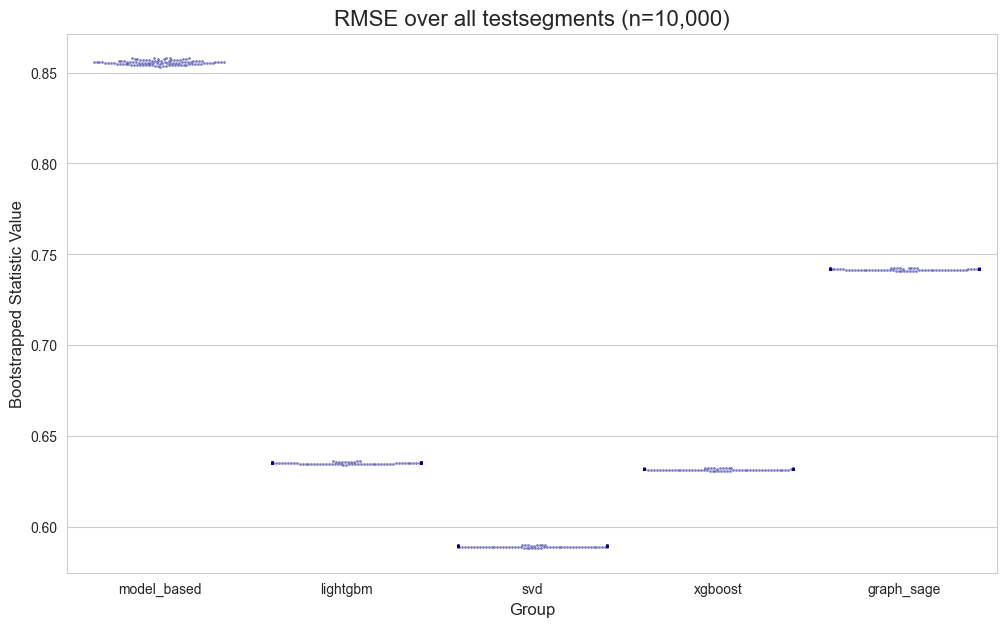

In [45]:
d = {
    "model_based": vincent_all_results["rmse_distribution"],
    "lightgbm": lightgbm_all_results["rmse_distribution"],
    "svd": svd_all_results["rmse_distribution"],
    "xgboost": xgboost_all_results["rmse_distribution"],
    "graph_sage": graph_sage_all_results["rmse_distribution"]
}
df_all = pd.DataFrame(data=d)
df_bootstrapped = df_all.melt(var_name='Group', value_name='Bootstrapped Statistic Value')
sns.set_style("whitegrid")
plt.figure(figsize=(12, 7))
plt.title('RMSE over all testsegments (n=10,000)', fontsize=16)
plt.xlabel('Group', fontsize=12)
plt.ylabel('Bootstrapped Statistic Value', fontsize=12)
sns.swarmplot(x='Group', y='Bootstrapped Statistic Value', data=df_bootstrapped, color="darkblue", size=2, alpha=0.5)
plt.show()


## RMSE regression evaluation

In [21]:
for segment_name, true_pred_seg_tuple in predicted_segments.items():
    print(f"Evaluating {segment_name}\n")
    y_true_df, y_pred_dfs = true_pred_seg_tuple
    for y_pred_name, y_pred_df in y_pred_dfs.items():
        aligned = align_dfs(y_true_df, y_pred_df)
        y_true = aligned['Rating_x'].values
        y_pred = aligned['Rating_y'].values
        if len(y_true) != len(y_pred):
            raise ValueError(f"Different amount of rating while evaluating {y_pred_name}")
        results = bootstrap_rmse(y_true, y_pred)
        print(f"{y_pred_name} lead to mean/ci: {results["mean"]}/{results["ci"]}")
    print("\n\n")

Evaluating Hot user/Hot Wine

vincent_warm_user_warm_item lead to mean/ci: 0.7950/[0.7927, 0.7972]
lightgbm_warm_user_warm_item lead to mean/ci: 0.6179/[0.6172, 0.6188]
svd_warm_user_warm_item lead to mean/ci: 0.5656/[0.5647, 0.5665]
xgboost_warm_user_warm_item lead to mean/ci: 0.6130/[0.6122, 0.6138]
graph_sage_warm_user_warm_item lead to mean/ci: 0.6505/[0.6496, 0.6514]



Evaluating Hot User/Cold Wine

vincent_warm_user_cold_item lead to mean/ci: 0.6848/[0.6784, 0.6919]
lightgbm_warm_user_cold_item lead to mean/ci: 0.6655/[0.6582, 0.6722]
svd_warm_user_cold_item lead to mean/ci: 0.6439/[0.6378, 0.6504]
xgboost_warm_user_cold_item lead to mean/ci: 0.6827/[0.6743, 0.6901]
graph_sage_warm_user_cold_item lead to mean/ci: 0.7845/[0.7778, 0.7920]



Evaluating Cold User/Hot Wine

vincent_cold_user_warm_item lead to mean/ci: 1.0739/[1.0687, 1.0790]
lightgbm_cold_user_warm_item lead to mean/ci: 0.6931/[0.6914, 0.6949]
svd_cold_user_warm_item lead to mean/ci: 0.6658/[0.6639, 0.6679]
xgboost_

## R² regression evaluation

In [16]:
for segment_name, true_pred_seg_tuple in predicted_segments.items():
    print(f"Evaluating {segment_name}\n")
    y_true_df, y_pred_dfs = true_pred_seg_tuple
    for y_pred_name, y_pred_df in y_pred_dfs.items():
        aligned = align_dfs(y_true_df, y_pred_df)
        y_true = aligned['Rating_x'].values
        y_pred = aligned['Rating_y'].values
        if len(y_true) != len(y_pred):
            raise ValueError(f"Different amount of rating while evaluating {y_pred_name}")
        results = r2_score(y_true, y_pred)
        print(f"{y_pred_name} lead to R²-score of {results}")
    print("\n\n")

Evaluating Hot user/Hot Wine

vincent_warm_user_warm_item lead to R²-score of -0.39197866210387367
lightgbm_warm_user_warm_item lead to R²-score of 0.15921614685234464
svd_warm_user_warm_item lead to R²-score of 0.2957298863986014
xgboost_warm_user_warm_item lead to R²-score of 0.1727261074617229
graph_sage_warm_user_warm_item lead to R²-score of 0.06849117644532976



Evaluating Hot User/Cold Wine

vincent_warm_user_cold_item lead to R²-score of -0.00010542898726328964
lightgbm_warm_user_cold_item lead to R²-score of 0.055213911430454066
svd_warm_user_cold_item lead to R²-score of 0.11537510864421929
xgboost_warm_user_cold_item lead to R²-score of 0.005710714268521211
graph_sage_warm_user_cold_item lead to R²-score of -0.3119048856206441



Evaluating Cold User/Hot Wine

vincent_cold_user_warm_item lead to R²-score of -1.0940425670816039
lightgbm_cold_user_warm_item lead to R²-score of 0.1276060087371772
svd_cold_user_warm_item lead to R²-score of 0.1949347050616379
xgboost_cold_user_

## RMSE classification evaluation

In [17]:
for segment_name, true_pred_seg_tuple in predicted_segments.items():
    print(f"Evaluating {segment_name}\n")
    y_true_df, y_pred_dfs = true_pred_seg_tuple
    for y_pred_name, y_pred_df in y_pred_dfs.items():
        y_pred_df["Rating"] = y_pred_df["Rating"].map(lambda x: round(x / 0.5) * 0.5)
        aligned = align_dfs(y_true_df, y_pred_df)
        y_true = aligned['Rating_x'].values
        y_pred = aligned['Rating_y'].values
        if len(y_true) != len(y_pred):
            raise ValueError(f"Different amount of rating while evaluating {y_pred_name}")
        results = bootstrap_rmse(y_true, y_pred)
        print(f"{y_pred_name} lead to mean/ci: {results["mean"]}/{results["ci"]}")
    print("\n\n")

Evaluating Hot user/Hot Wine

vincent_warm_user_warm_item lead to mean/ci: 0.8077/[0.8053, 0.8098]
lightgbm_warm_user_warm_item lead to mean/ci: 0.6343/[0.6336, 0.6353]
svd_warm_user_warm_item lead to mean/ci: 0.5837/[0.5829, 0.5845]
xgboost_warm_user_warm_item lead to mean/ci: 0.6299/[0.6291, 0.6307]
graph_sage_warm_user_warm_item lead to mean/ci: 0.6651/[0.6641, 0.6660]



Evaluating Hot User/Cold Wine

vincent_warm_user_cold_item lead to mean/ci: 0.6977/[0.6905, 0.7052]
lightgbm_warm_user_cold_item lead to mean/ci: 0.6829/[0.6752, 0.6895]
svd_warm_user_cold_item lead to mean/ci: 0.6600/[0.6541, 0.6669]
xgboost_warm_user_cold_item lead to mean/ci: 0.7006/[0.6923, 0.7072]
graph_sage_warm_user_cold_item lead to mean/ci: 0.7992/[0.7927, 0.8064]



Evaluating Cold User/Hot Wine

vincent_cold_user_warm_item lead to mean/ci: 1.0828/[1.0775, 1.0876]
lightgbm_cold_user_warm_item lead to mean/ci: 0.7083/[0.7066, 0.7102]
svd_cold_user_warm_item lead to mean/ci: 0.6815/[0.6796, 0.6835]
xgboost_

## Precision, Recall, F1, Confusion Matrices

Evaluating Hot user/Hot Wine



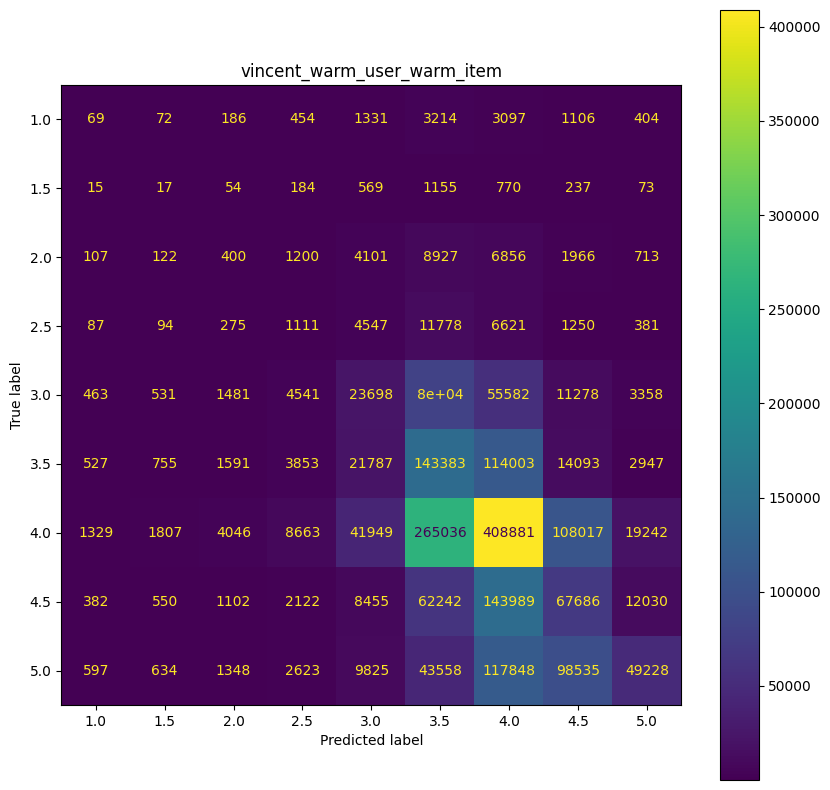

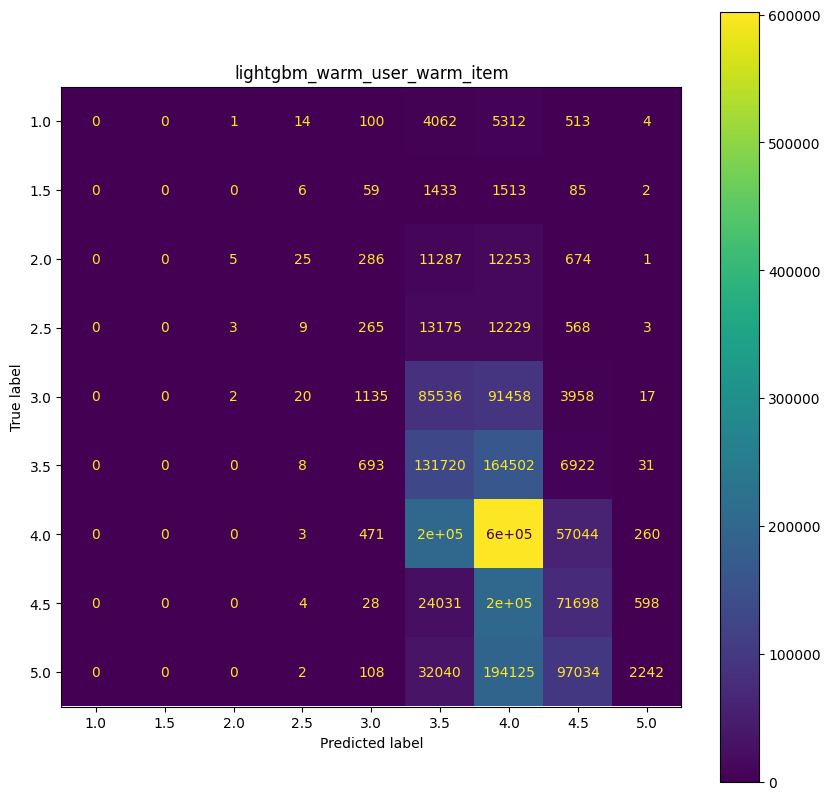

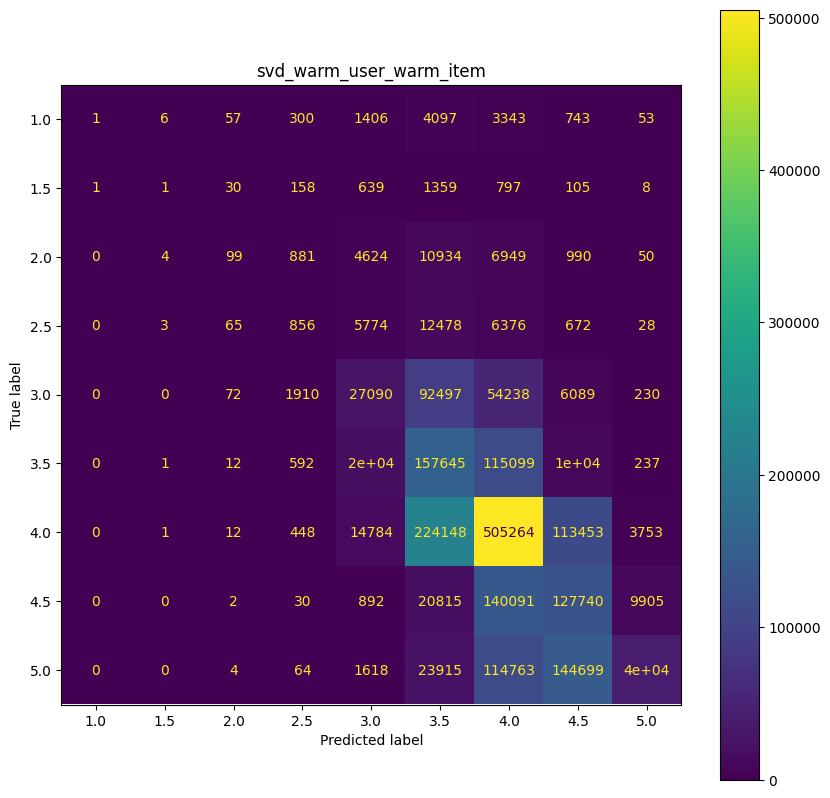

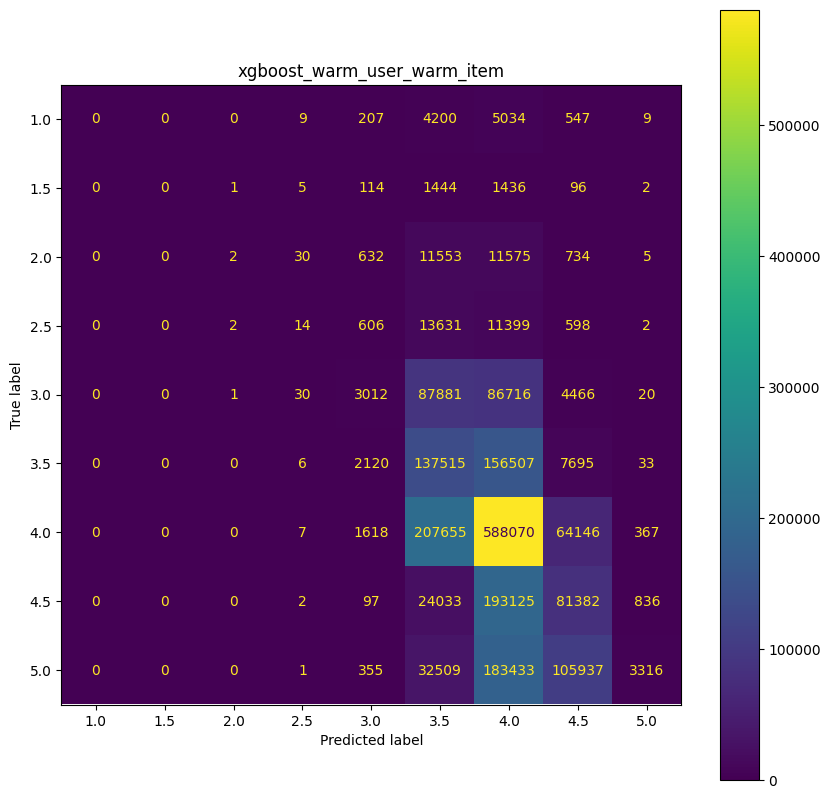

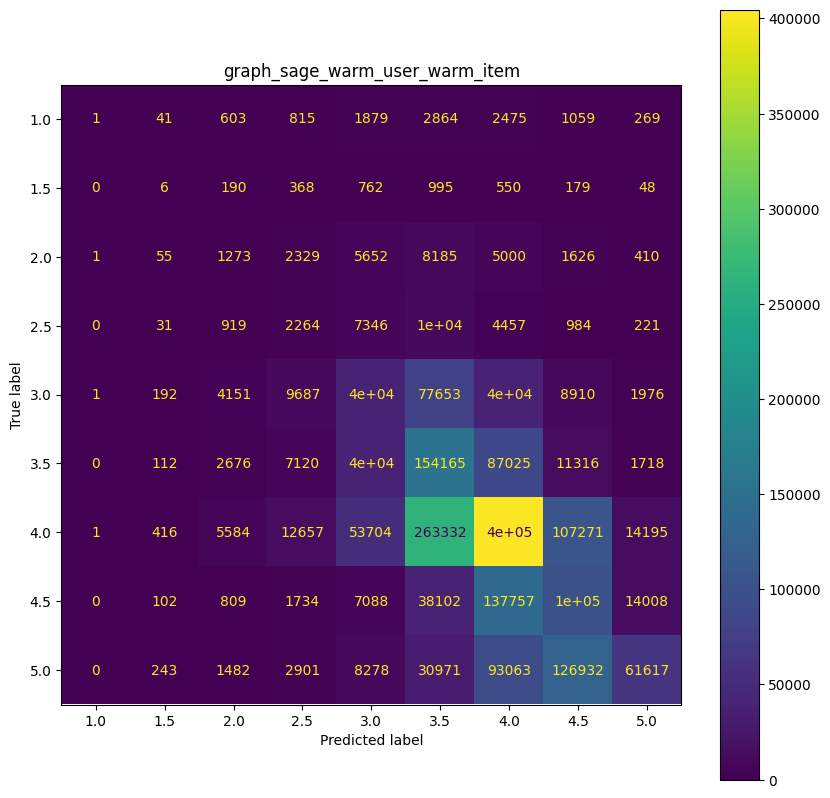




Evaluating Hot User/Cold Wine



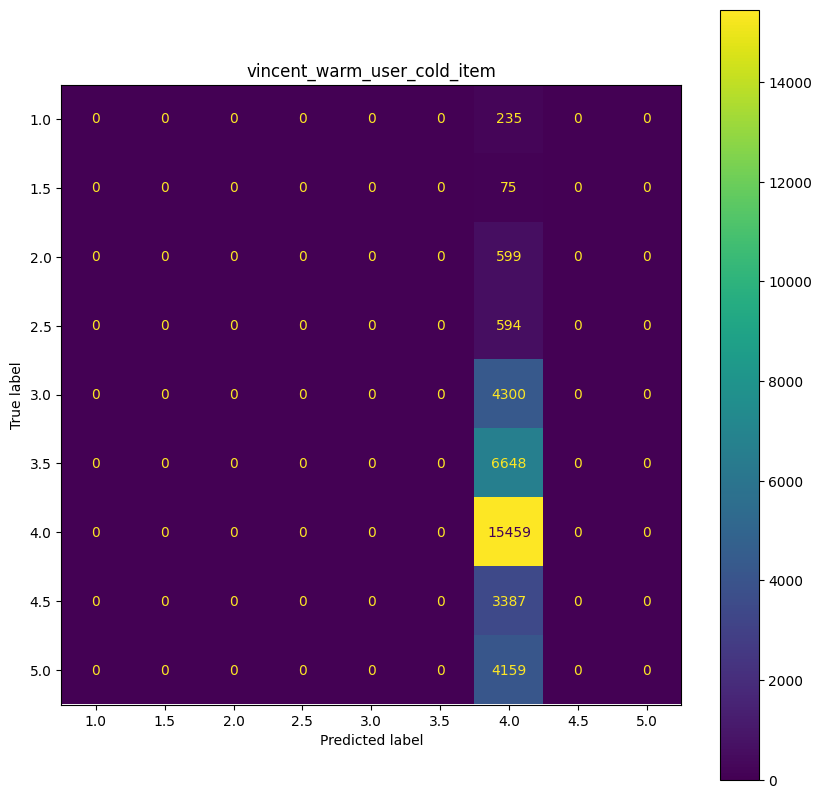

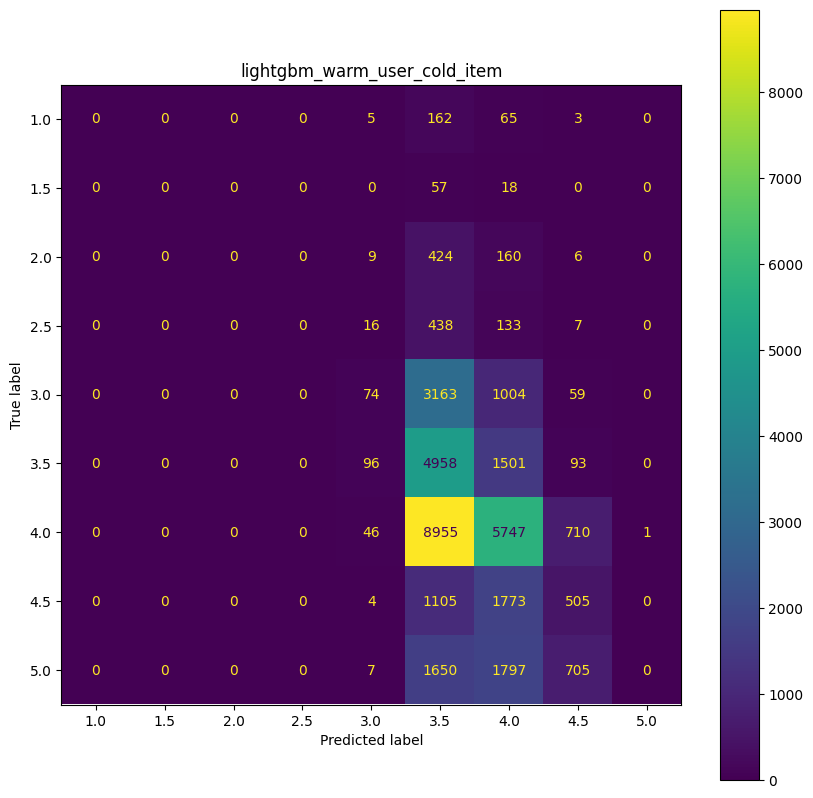

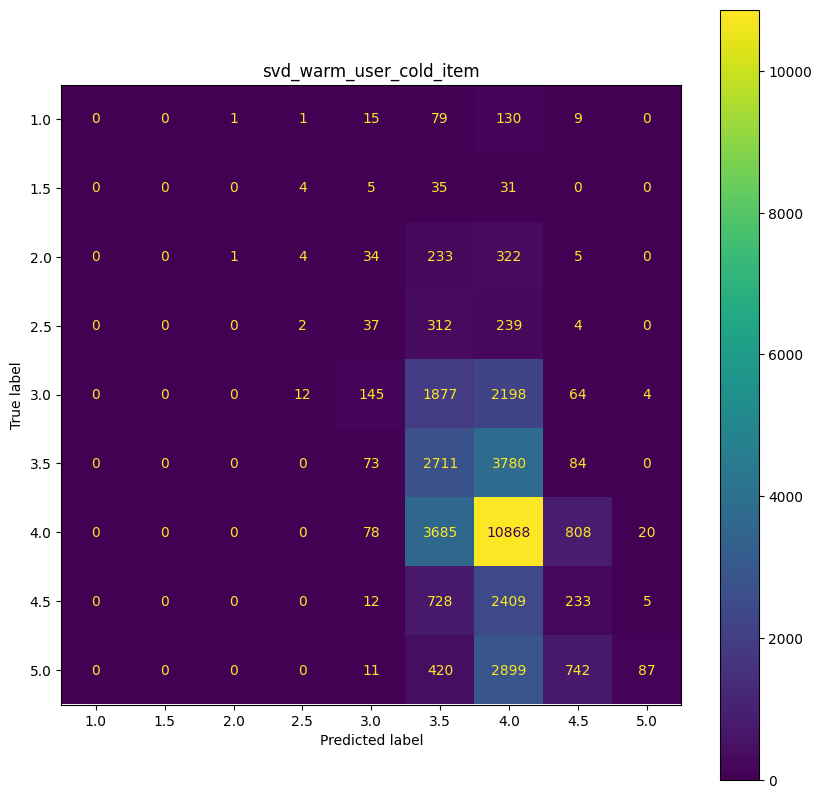

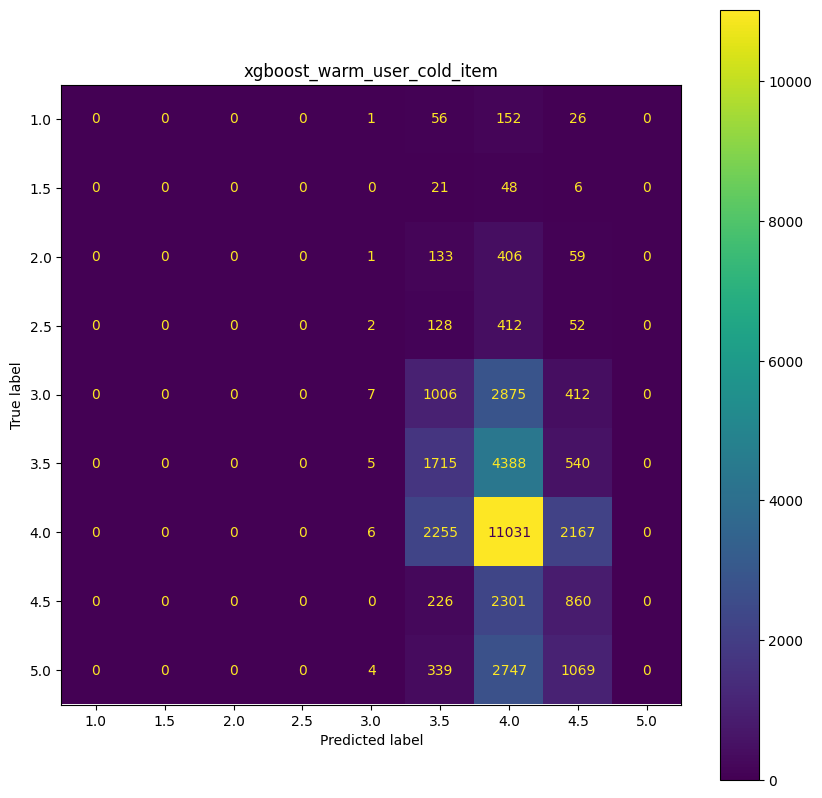

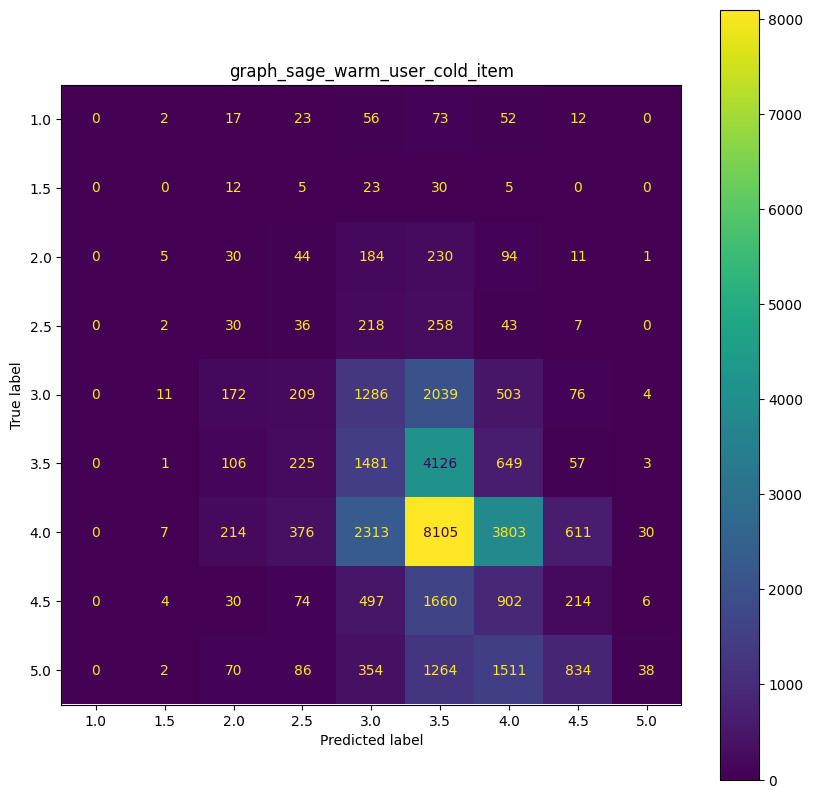




Evaluating Cold User/Hot Wine



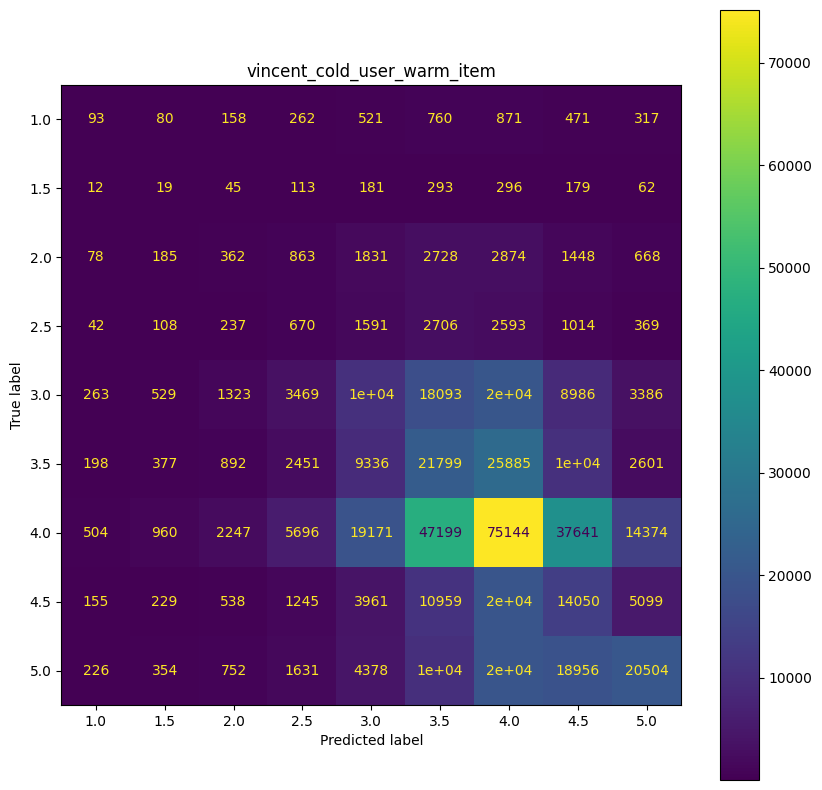

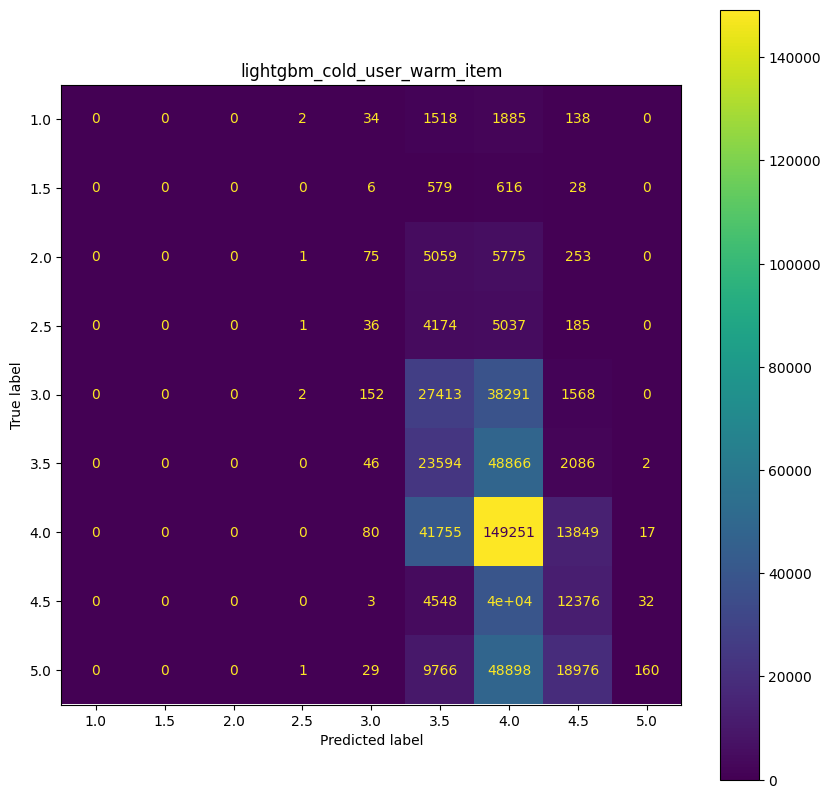

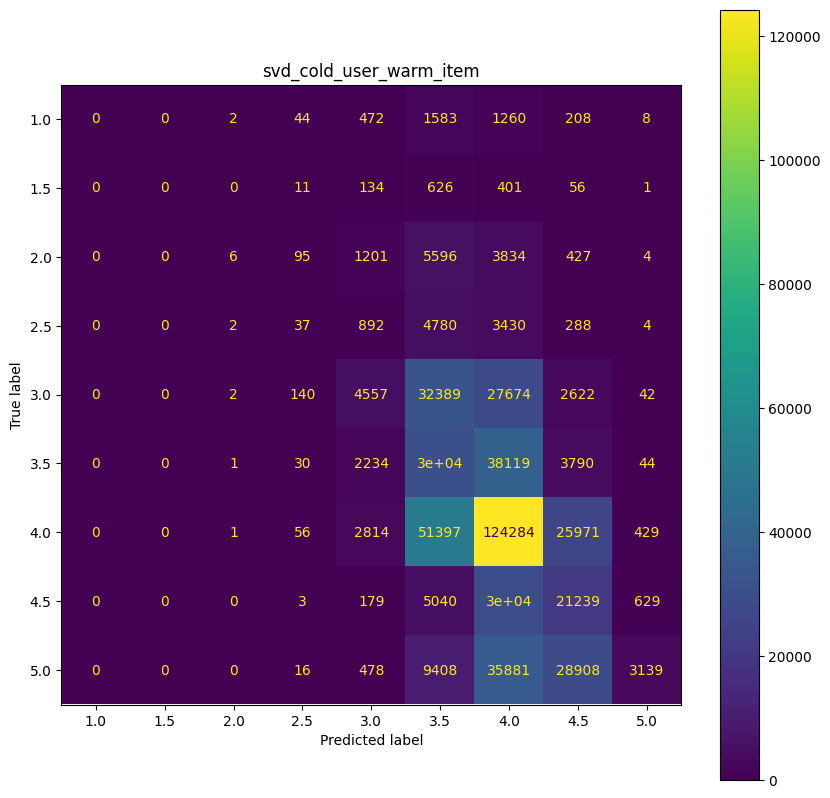

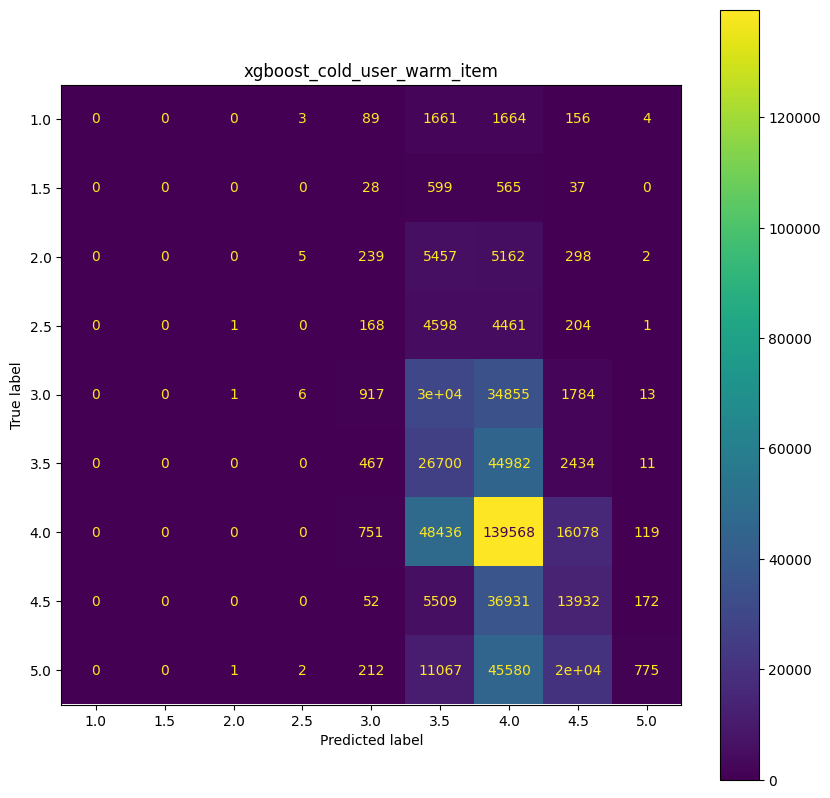

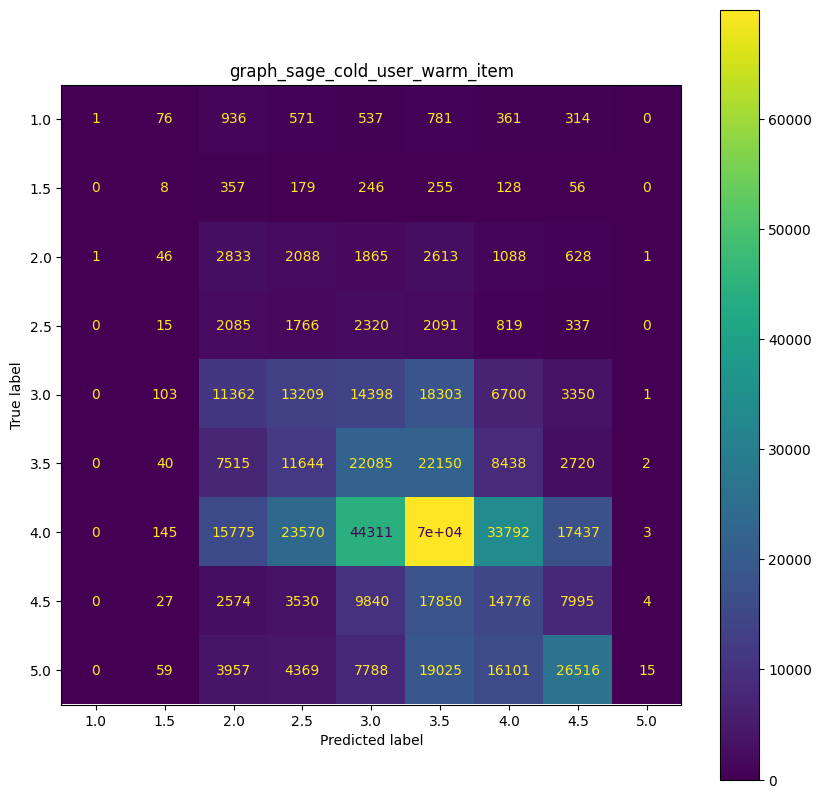




Evaluating Cold User/Cold Wine



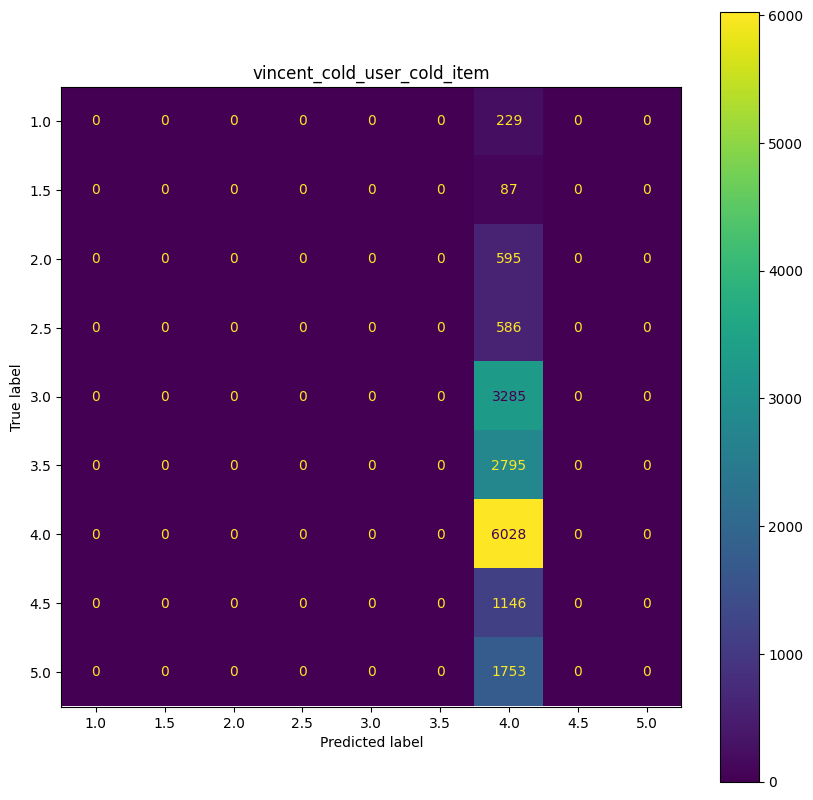

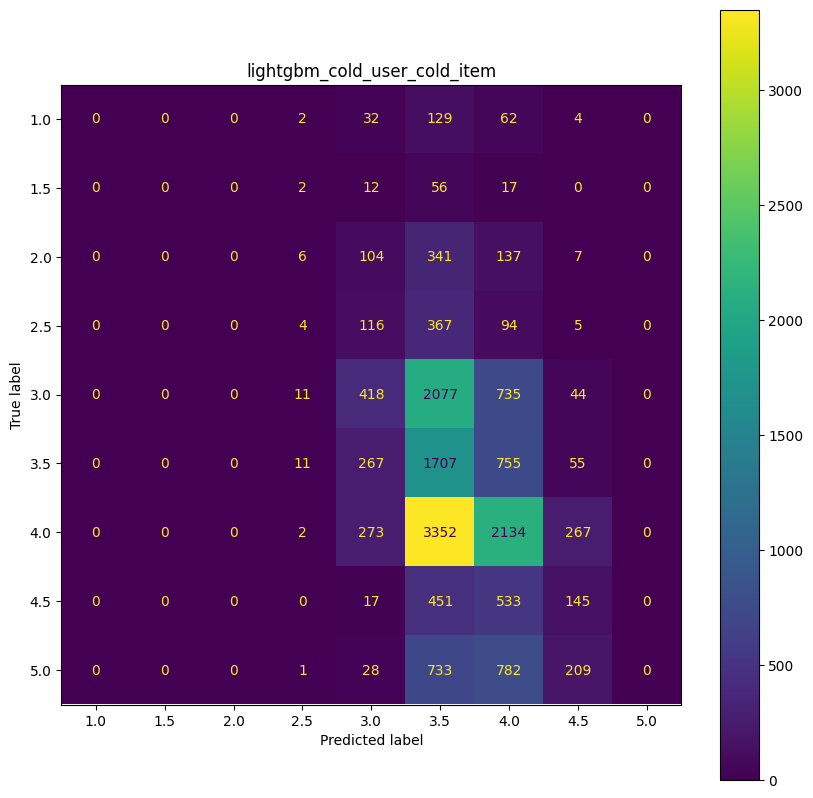

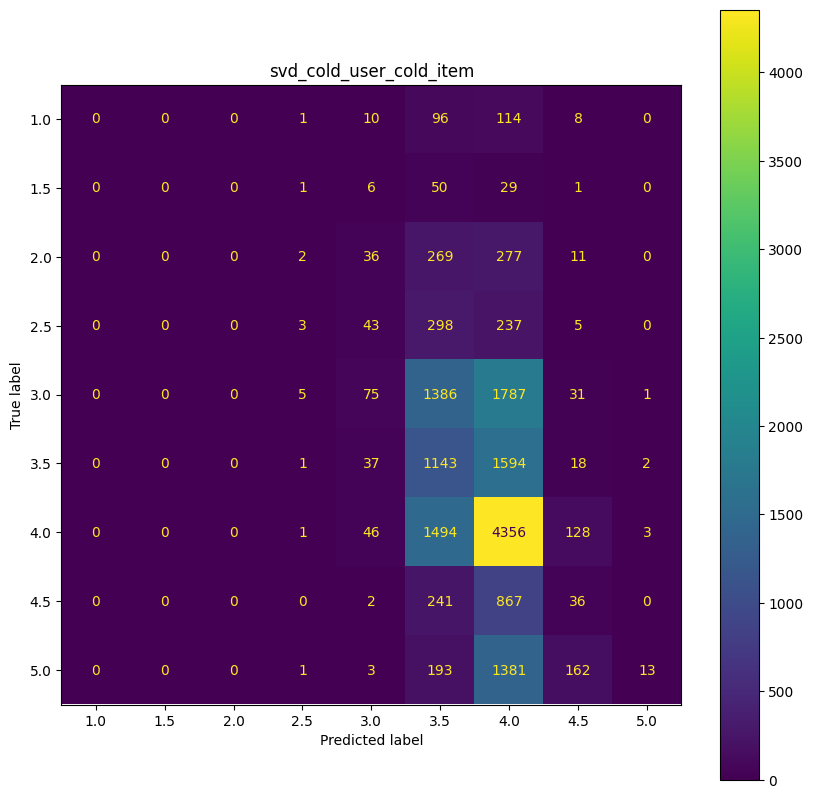

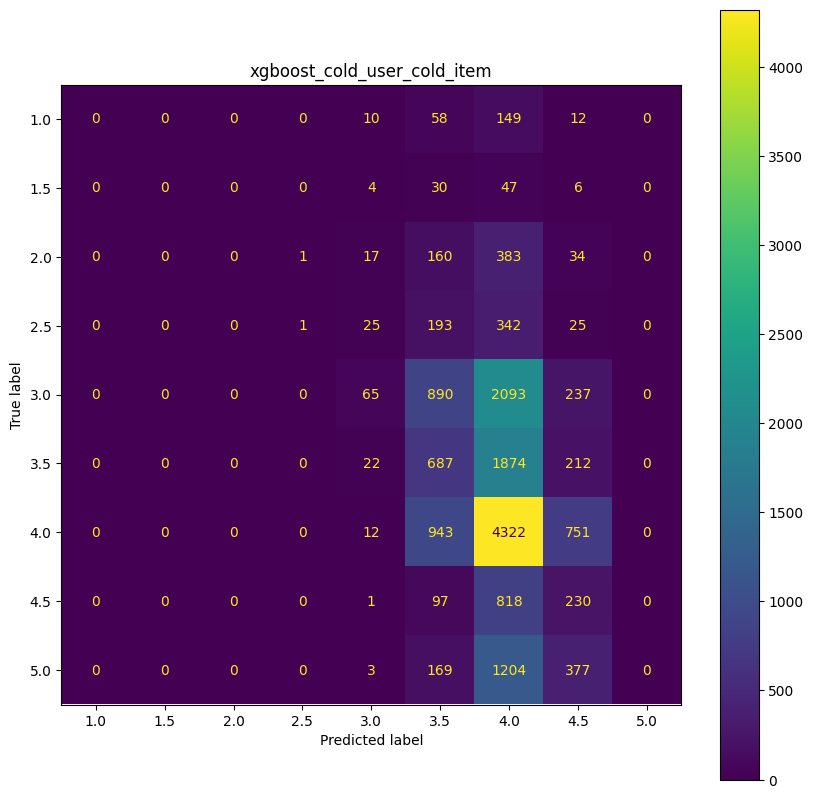

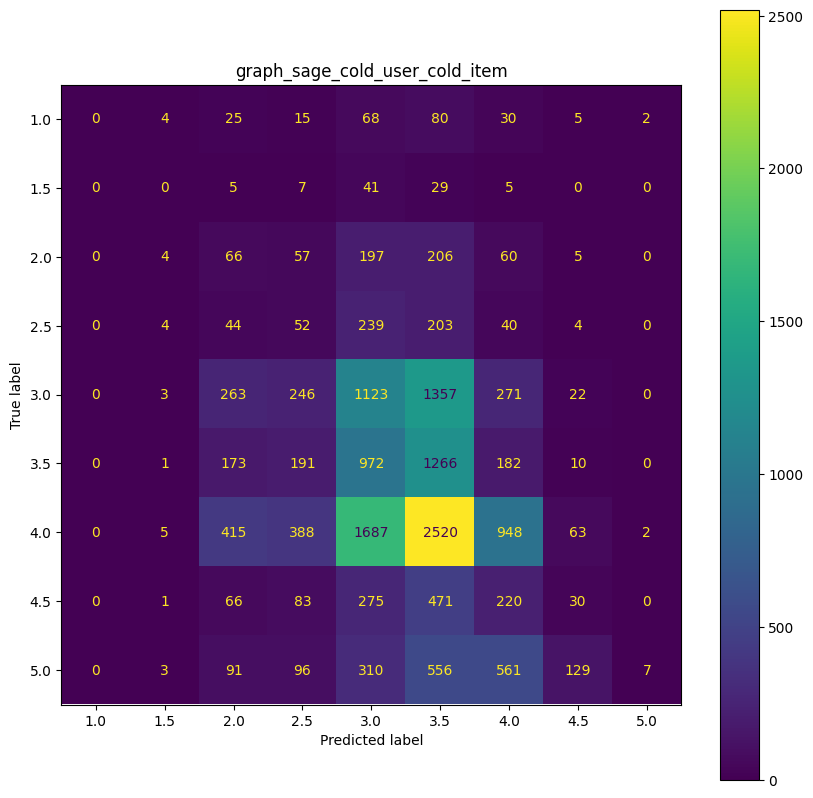

In [18]:
for segment_name, true_pred_seg_tuple in predicted_segments.items():
    print(f"Evaluating {segment_name}\n")
    y_true_df, y_pred_dfs = true_pred_seg_tuple
    for y_pred_name, y_pred_df in y_pred_dfs.items():
        y_pred_df["Rating"] = y_pred_df["Rating"].map(lambda x: round(x / 0.5) * 0.5)
        aligned = align_dfs(y_true_df, y_pred_df)
        y_true = aligned['Rating_x'].values
        y_true = [str(y) for y in y_true]
        y_pred = aligned['Rating_y'].values
        y_pred = [str(y) for y in y_pred]
        if len(y_true) != len(y_pred):
            raise ValueError(f"Different amount of rating while evaluating {y_pred_name}")
        cm = confusion_matrix(y_true, y_pred, labels=["1.0", "1.5", "2.0", "2.5", "3.0", "3.5", "4.0", "4.5", "5.0"])
        cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["1.0", "1.5", "2.0", "2.5", "3.0", "3.5", "4.0", "4.5", "5.0"])
        fig, ax = plt.subplots(figsize=(10,10))
        ax.set_title(f"{y_pred_name}")
        cmd.plot(ax=ax)
        plt.show()
    print("\n\n")

In [ ]:
aligned = align_dfs(true_cold_user_cold_item, vincent_cold_user_cold_item)
y_true = aligned['Rating'].values
y_pred = aligned['PredictedRating'].values
if len(y_true) != len(y_pred):
    raise ValueError("Different amount of rating")
results = bootstrap_rmse(y_true, y_pred)
print(f"{results["mean"]}/{results["ci"]}")

In [ ]:
plt.hist(results["rmse_distribution"])

In [ ]:
aligned = align_dfs(true_warm_user_warm_item, lightgbm_warm_user_warm_item)
y_true = aligned['Rating_x'].values
y_pred = aligned['Rating_y'].values
if len(y_true) != len(y_pred):
    raise ValueError("Different amount of rating")
results = bootstrap_rmse(y_true, y_pred)
print(f"{results["mean"]}/{results["ci"]}")

In [ ]:
plt.hist(results["rmse_distribution"])

In [ ]:
aligned = align_dfs(true_cold_user_warm_item, lightgbm_cold_user_warm_item)
y_true = aligned['Rating_x'].values
y_pred = aligned['Rating_y'].values
if len(y_true) != len(y_pred):
    raise ValueError("Different amount of rating")
results = bootstrap_rmse(y_true, y_pred)
print(f"{results["mean"]}/{results["ci"]}")

In [ ]:
plt.hist(results["rmse_distribution"])

In [ ]:
aligned = align_dfs(true_cold_user_cold_item, lightgbm_cold_user_cold_item)
y_true = aligned['Rating_x'].values
y_pred = aligned['Rating_y'].values
if len(y_true) != len(y_pred):
    raise ValueError("Different amount of rating")
results = bootstrap_rmse(y_true, y_pred)
print(f"{results["mean"]}/{results["ci"]}")

In [ ]:
plt.hist(results["rmse_distribution"])

##### Hot user, Hot Wine

In [ ]:
aligned = align_dfs(true_warm_user_warm_item, svd_warm_user_warm_item)
y_true = aligned['Rating_x'].values
y_pred = aligned['Rating_y'].values
if len(y_true) != len(y_pred):
    raise ValueError("Different amount of rating")
results = bootstrap_rmse(y_true, y_pred)
print(f"{results["mean"]}/{results["ci"]}")

In [ ]:
plt.hist(results["rmse_distribution"])

##### Hot user, Cold Wine

In [ ]:
aligned = align_dfs(true_warm_user_cold_item, svd_warm_user_cold_item)
y_true = aligned['Rating_x'].values
y_pred = aligned['Rating_y'].values
if len(y_true) != len(y_pred):
    raise ValueError("Different amount of rating")
results = bootstrap_rmse(y_true, y_pred)
print(f"{results["mean"]}/{results["ci"]}")

In [ ]:
plt.hist(results["rmse_distribution"])

##### Cold user, Hot Wine

In [ ]:
aligned = align_dfs(true_cold_user_warm_item, svd_cold_user_warm_item)
y_true = aligned['Rating_x'].values
y_pred = aligned['Rating_y'].values
if len(y_true) != len(y_pred):
    raise ValueError("Different amount of rating")
results = bootstrap_rmse(y_true, y_pred)
print(f"{results["mean"]}/{results["ci"]}")

In [ ]:
plt.hist(results["rmse_distribution"])

##### Cold user, Cold Wine

In [ ]:
aligned = align_dfs(true_cold_user_cold_item, svd_cold_user_cold_item)
y_true = aligned['Rating_x'].values
y_pred = aligned['Rating_y'].values
if len(y_true) != len(y_pred):
    raise ValueError("Different amount of rating")
results = bootstrap_rmse(y_true, y_pred)
print(f"{results["mean"]}/{results["ci"]}")

In [ ]:
plt.hist(results["rmse_distribution"])

In [ ]:
aligned = align_dfs(true_warm_user_cold_item, xgboost_warm_user_cold_item)
y_true = aligned['Rating_x'].values
y_pred = aligned['Rating_y'].values
if len(y_true) != len(y_pred):
    raise ValueError("Different amount of rating")
results = bootstrap_rmse(y_true, y_pred)
print(f"{results["mean"]}/{results["ci"]}")

In [ ]:
plt.hist(results["rmse_distribution"])

In [ ]:
aligned = align_dfs(true_cold_user_warm_item, xgboost_cold_user_warm_item)
y_true = aligned['Rating_x'].values
y_pred = aligned['Rating_y'].values
if len(y_true) != len(y_pred):
    raise ValueError("Different amount of rating")
results = bootstrap_rmse(y_true, y_pred)
print(f"{results["mean"]}/{results["ci"]}")

In [ ]:
plt.hist(results["rmse_distribution"])

In [ ]:
aligned = align_dfs(true_cold_user_cold_item, xgboost_cold_user_cold_item)
y_true = aligned['Rating_x'].values
y_pred = aligned['Rating_y'].values
if len(y_true) != len(y_pred):
    raise ValueError("Different amount of rating")
results = bootstrap_rmse(y_true, y_pred)
print(f"{results["mean"]}/{results["ci"]}")

In [ ]:
plt.hist(results["rmse_distribution"])

In [ ]:
for _ in range(1000):
    idx = rng.choice(len(y_true), size=len(y_true), replace=True)
    rmse_a = root_mean_squared_error(y_true[idx], y_pred_a[idx])
    rmse_b = root_mean_squared_error(y_true[idx], y_pred_b[idx])
    diff = mae_b - mae_a  # Positive means A is better
    diff_scores.append(diff)
